# EzHoloPy

统一单位：cm

Model: 导入的3D模型
Points: 3D模型的点云
T(t): 时间(t)依赖变换3x3矩阵 t [-pi, pi]
Vx(t), Vy(t), Vz(t): 视点的位置 t [-pi, pi]

1. 读取3D模型
2. 读取点云列表
[(x,y,z),
(x,y,z),
(x,y,z),
(x,y,z),
...]


3. 建立一个2维列表，存储每个点映射到刮擦板上的坐标,最终经过映射我们将得到类似如下的结果

[[(x1, y1), (x2, y2), ...], # 0号点映射到刮擦板上的坐标
[(x1, y1), (x2, y2), ...], # 1号点映射到刮擦板上的坐标
[(x1, y1), (x2, y2), ...], # 2号点映射到刮擦板上的坐标
[(x1, y1), (x2, y2), ...], # 3号点映射到刮擦板上的坐标
...]

4. 导出刮擦板上的坐标到SVG文件
5. 后续工作:blender渲染 或者 交由雕刻机/写字机进行刮擦板的制作





In [1]:
import numpy as np
import struct

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

import os
from xml.dom.minidom import Document

import time

MAXMIMUM_POINTS = 1000

# 第一步 配置导入模型文件名、精度、相机位置、理想模型尺寸

## 1.1 导入模型文件名

.stl文件

例
```python
file_path = 'model.stl'
```



## 1.2 精度与插值密度

### 1.2.1 导入精度

越接近0越精确，但是计算量也会大幅增加

例
```python
precision = 0.1
```

### 1.2.2 插值密度

以density为密度，在关键顶点之间插入点

例
```python
density = 10
```

## 1.3 相机位置

相机初始位置，单位cm

例
```python
camera = np.array([0, 10, 20]) # 距离原点10cm，高度20cm
```


## 1.4 理想模型尺寸

模型的理想尺寸，表示制作成刮擦全息板后立体图形的尺寸，单位cm，将按照最长边等比例缩放

例
```python
size3D = np.array([5, 5, 5]) # 长宽高均为5cm
```

# 第二步 定义模型变换矩阵T(t)和视点变换矩阵V(t)

## 2.1 定义模型变换矩阵(t)

模型变换矩阵，t为时间，t的范围为[0, 2pi]

例
```python
# 举个例子，每个t绕x轴旋转pi度
def T(t):
    return np.array([[1, 0, 0],
                     [0, np.cos(t), -np.sin(t)],
                     [0, np.sin(t), np.cos(t)]])
```

## 2.2 定义视点变换矩阵(t)

视点变换矩阵，t为时间，t的范围为[0, 2pi]

例
```python
def V(t):
    return np.array([[np.cos(t), -np.sin(t), 0],
                     [np.sin(t), np.cos(t), 0],
                     [0, 0, 1]])
```

In [2]:
# 配置导入的stl文件路径
file_path = 'cone.STL'

In [3]:
# 配置加载精度
precision = 0
# 配置插值密度 (Point per cm)
lindensity = 5

# 配置帧数
frame = 100

In [4]:
# 定义模型期望大小
size3D = np.array([5, 5, 5])

In [5]:

# 定义Camera位置

# 1.类黑胶，旋转全息，绕z轴旋转，物体固定

camera = np.array([0, 10, 30])
def T(t):
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])
    
def V(t):
    return np.array([[np.cos(t), -np.sin(t), 0],
                     [np.sin(t), np.cos(t), 0],
                     [0, 0, 1]])
                     
'''
# 2.全息画像，视点绕y轴旋转，物体绕y轴与视点反向旋转
camera = np.array([-10, 0, 10])
def T(t):
    return np.array([[np.cos(-t/3), 0, np.sin(-t/3)],
                     [0, 1, 0],
                     [-np.sin(-t/3), 0, np.cos(-t/3)]])'''
'''
def V(t):
    return np.array([[np.cos(t/3), 0, np.sin(t/3)],
                     [0, 1, 0],
                     [-np.sin(t/3), 0, np.cos(t/3)]])'''


#使视点从-10绕z轴旋转到+10,半径为20
def Vx(t,A): # [0，2pi] to [-10,10]
    return A*np.cos(t/2)


def Vy(t,B):
    return B*np.sin(t/2)







# 第三步 配置导出

## 3.1 标准化尺寸

SVG文件的尺寸

例
```python
sizeSVG = 1000 # 将长边缩放到1000
```


In [6]:
# SVG文件的尺寸
sizeSVG = 1024

In [7]:
def read_stl(file_path):
    """
    从 STL 文件读取三角面片的顶点。
    
    Args:
        file_path (str): STL 文件路径。
        
    Returns:
        np.ndarray: 一个形状为 (count, 3, 3) 的数组，表示每个三角形的三个顶点坐标。
    """
    with open(file_path, 'rb') as f:
        f.seek(80)  # 跳过 80 字节的文件头
        count = struct.unpack('I', f.read(4))[0]  # 读取三角形数量
        vertices = np.zeros((count, 3, 3), dtype=np.float32)
        for i in range(count):
            f.seek(12, 1)  # 跳过法向量
            data = struct.unpack('fff'*3, f.read(36))  # 读取三角形三个顶点
            vertices[i] = np.array(data).reshape(3, 3)  # 将数据重塑为 (3, 3)
            f.seek(2, 1)  # 跳过属性字节
    print(f"已从 {file_path} 加载 {count} 面")
    return vertices

def read_point_cloud(vertices, detail, density):
    """
    从三角面片中提取去重后的点云。
    
    Args:
        vertices (np.ndarray): 一个形状为 (count, 3, 3) 的数组，表示每个三角形的三个顶点。
        detail (float): 0+，精度，越小越精确，越大越模糊

    Returns:
        np.ndarray: 一个形状为 (n, 3) 的数组，表示去重后的点云。
    """

    if density > 0:
        points = []
        for triangle in vertices:
            for i in range(3):
                p1 = triangle[i]
                p2 = triangle[(i + 1) % 3]
                length = np.linalg.norm(p2 - p1)
                count = int(length * density)
                for j in range(count):
                    points.append(p1 + (p2 - p1) * j / count)
        points = np.array(points)
        if(len(points) ==0):
            points = vertices.reshape(-1, 3)
        print(f"完整加载, 插值后 {points.shape[0]} 点")
    else:
        # 将三角形的三个顶点展平为一个大的 (count * 3, 3) 数组
        points = vertices.reshape(-1, 3)
    
 
    # 使用 numpy.unique 去重，并保留坐标顺序
    unique_points = np.unique(points, axis=0)
    original_count = unique_points.shape[0]
    # 将密集的点合并
    if detail > 0:
        up = np.round(unique_points / detail) * detail
        up = np.unique(up, axis=0)
        while(up.shape[0] > MAXMIMUM_POINTS):     
            print(f"{original_count} 点 => 加载精度{detail} => {up.shape[0]} 点\033[1;30;43m> 预设最大值({MAXMIMUM_POINTS}) 重试\033[0m")    
            detail *= 1.1        
            up = np.round(unique_points / detail) * detail
            up = np.unique(up, axis=0)
        print(f"{original_count} 点 => 加载精度{detail} => {up.shape[0]} 点")
        unique_points = up
    else:
        unique_points = np.unique(unique_points, axis=0)
        print(f"完整加载 {unique_points.shape[0]} 点")
            
    return unique_points

def get_boundary(cloud):
    """
    从点云中提取边界点。
    
    Args:
        cloud (np.ndarray): 一个形状为 (n, 3) 的数组，表示点云。
        
    Returns:
        mx_min, mx_max, my_min, my_max, mz_min, mz_max: 边界点坐标
    """
    mx_min, my_min, mz_min = np.min(cloud, axis=0)
    mx_max, my_max, mz_max = np.max(cloud, axis=0)
    return mx_min, mx_max, my_min, my_max, mz_min, mz_max

def scale(cloud, size):
    """
    将点云缩放到指定大小。
    
    Args:
        cloud (np.ndarray): 一个形状为 (n, 3) 的数组，表示点云。
        size (np.ndarray): 一个形状为 (3,) 的数组，表示期望大小。
        
    Returns:
        np.ndarray: 一个形状为 (n, 3) 的数组，表示缩放后的点云。
    """
    mx_min, mx_max, my_min, my_max, mz_min, mz_max = get_boundary(cloud)
    print(f"原始边界: {mx_min:.2f} {mx_max:.2f} {my_min:.2f} {my_max:.2f} {mz_min:.2f} {mz_max:.2f}")
    scale = np.min(size) / np.max([mx_max - mx_min, my_max - my_min, mz_max - mz_min])
    return cloud * scale


已从 cone.STL 加载 62 面
完整加载, 插值后 858 点
完整加载 727 点
原始边界: -1.00 1.00 -1.00 1.00 -1.00 1.00


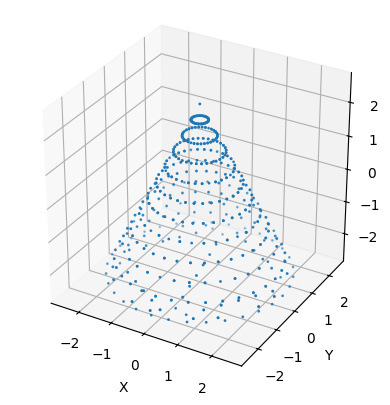

In [8]:

vertices = read_stl(file_path)  # 读取 STL 文件

cloud = scale(read_point_cloud(vertices,precision,lindensity),size3D)  # 提取点云

# 预览点云
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# 等轴比例
ax.set_aspect('equal')
plt.show()


In [9]:

# 如果camera在cloud boundary内，警告
mx_min, mx_max, my_min, my_max, mz_min, mz_max = get_boundary(cloud)
print(f"{file_path} 模型边界：")
print(f"X: {mx_min:.8f} ~ {mx_max:.8f}")
print(f"Y: {my_min:.8f} ~ {my_max:.8f}")
print(f"Z: {mz_min:.8f} ~ {mz_max:.8f}")
if camera[0] > mx_min and camera[0] < mx_max:
    print(f"\033[1;30;43m警告: Camera X = {camera[0]} 在模型边界内")
if camera[1] > my_min and camera[1] < my_max:
    print(f"\033[1;30;43m警告: Camera Y = {camera[1]} 在模型边界内")
if camera[2] > mz_min and camera[2] < mz_max:
    print(f"\033[1;30;43m警告: Camera Z = {camera[2]} 在模型边界内")

print("\033[0m")

cone.STL 模型边界：
X: -2.50000000 ~ 2.50000000
Y: -2.50000000 ~ 2.50000000
Z: -2.50000000 ~ 2.50000000
警告: Camera X = 0 在模型边界内



In [10]:
# nx = (1-(cx-px)/(cz-pz))*px
# ny = (1-(cy-py)/(cz-pz))*py

import numpy as np
from tqdm import tqdm

t = np.linspace(-np.pi, np.pi, frame)
#t = np.linspace(-np.pi+0.5, np.pi-0.5, frame)

resultcloud = []

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_aspect('equal')
#a=0
for i in tqdm(t, desc="Processing"):
    #a+=1
    # 模型变换
    trans = np.dot(cloud, T(i))

    # 视点变换&投影
    trans = trans - np.dot(camera, V(i))
    #trans = trans - np.array([Vx(i,1),Vy(i,5),6])
    depth = trans[:, 2].reshape(-1, 1)
    cloud2d = trans / depth
    # 伪代码 cloud2d + [0,0,depth - 1]
    #cloud2d = cloud2d - np.array([0,0,1]) * (depth - 1)
    resultcloud.append(cloud2d)
    #ax.scatter(cloud2d[:, 0], cloud2d[:, 1], s=1)
    #if a%10 == 0:
    #    plt.savefig(f"output/frame{a}.png")
#print(resultcloud[0])




npresultcloud = np.array(resultcloud)
print(npresultcloud.shape)




Processing: 100%|██████████| 100/100 [00:00<00:00, 31533.75it/s]

(100, 727, 3)


In [11]:
# 归一化处理
x_all = npresultcloud[:, :, 0].flatten()
y_all = npresultcloud[:, :, 1].flatten()

x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = y_all.min(), y_all.max()

ori_width = x_max - x_min
ori_height = y_max - y_min

x_normalized = lambda x: sizeSVG * (x - x_min) / (ori_width)
y_normalized = lambda y: sizeSVG * (y - y_min) / (ori_height)


# 创建 SVG 文件
doc = Document()
svg = doc.createElement("svg")
svg.setAttribute("xmlns", "http://www.w3.org/2000/svg")
svg.setAttribute("version", "1.1")
svg.setAttribute("width", str(sizeSVG))
svg.setAttribute("height", str(sizeSVG))
svg.setAttribute("viewBox", f"0 0 {sizeSVG} {sizeSVG}")  # 添加 viewBox
doc.appendChild(svg)

for i in range(npresultcloud.shape[1]):
    x = npresultcloud[:, i, 0]
    y = npresultcloud[:, i, 1]

    # 创建 polyline 节点
    polyline = doc.createElement("polyline")
    points_str = " ".join(f"{x_normalized(px)},{y_normalized(py)}" for px, py in zip(x, y))
    polyline.setAttribute("points", points_str)
    polyline.setAttribute("style", "fill:none;stroke:black;stroke-width:0.1")
    svg.appendChild(polyline)

# 保存 SVG 文件
if not os.path.exists("outputs"):
    os.mkdir("outputs")

filename = f"outputs/C_{file_path.split('.')[0]}_{time.strftime('%H%M%S', time.localtime())}.svg"

with open(filename, "w") as f:
    f.write(doc.toprettyxml(indent="  "))
print(f"已保存到 {filename}")
print(f"曲线数量：{npresultcloud.shape[1]}")


已保存到 output/C_cone_161053.svg
曲线数量：727


In [12]:
import numpy as np
from PIL import Image, ImageDraw, ImageFilter

def curves_to_height_map(curves, 
                         width=512, 
                         height=512, 
                         line_color=100, 
                         line_width=1, 
                         blur_radius=1,
                         filename_height="height_map.png"):
    """
    将给定的曲线数据转换为高度图（灰度图）。
    
    参数：
    - curves: numpy数组, 形状为 (num_points, num_curves, 3)，表示多条曲线的数据点。每个点为 (X, Y, 0)。
    - width, height: 输出图像的分辨率。
    - line_color: 绘制曲线使用的灰度值 (0-255)。小于128表示凹陷，大于128表示凸起。
    - line_width: 曲线的绘制宽度。
    - blur_radius: 对高度图进行高斯模糊的半径。
    - filename_height: 保存高度图的文件名。
    
    返回：
    - height_map (numpy array): 生成的高度图的numpy数组 (height, width), dtype=uint8。
    """
    num_points, num_curves, _ = curves.shape

    # 提取坐标范围
    x_coords = curves[:,:,0]
    y_coords = curves[:,:,1]
    xmin, xmax = x_coords.min(), x_coords.max()
    ymin, ymax = y_coords.min(), y_coords.max()

    # 坐标转换函数：世界坐标->图像坐标
    def world_to_image(x, y, xmin, xmax, ymin, ymax, width, height):
        ix = (x - xmin) / (xmax - xmin) * (width - 1)
        iy = (y - ymin) / (ymax - ymin) * (height - 1)
        return ix, iy

    # 创建基础高度图(128灰度)
    height_map = np.full((height, width), 255, dtype=np.uint8)
    img = Image.fromarray(height_map, mode='L')
    draw = ImageDraw.Draw(img)

    # 绘制每条曲线
    for c in range(num_curves):
        curve_points = curves[:, c, :]  # (num_points, 3)
        xs = curve_points[:, 0]
        ys = curve_points[:, 1]

        img_points = []
        for i in range(num_points):
            ix, iy = world_to_image(xs[i], ys[i], xmin, xmax, ymin, ymax, width, height)
            img_points.append((ix, iy))

        # 在高度图上绘制曲线
        draw.line(img_points, fill=line_color, width=line_width)

    # 对绘制完成的高度图进行模糊
    if blur_radius > 0:
        img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    height_map = np.array(img, dtype=np.uint8)
    img.save(filename_height)

    return height_map

def height_map_to_normal_map(height_map, filename_normal="normal_map.png"):
    """
    将高度图转换为法线贴图。
    
    参数：
    - height_map: numpy数组，shape为(height, width)，存储0-255灰度值的高度信息。
    - filename_normal: 保存法线贴图的文件名。
    
    返回：
    - normal_map (numpy array): 生成的法线贴图 (height, width, 3), dtype=uint8。
    """
    # 高度归一化到0~1
    hmap = height_map.astype(np.float32) / 255.0

    Nx = np.zeros_like(hmap)
    Ny = np.zeros_like(hmap)

    # 有限差分计算梯度
    Nx[:, 1:-1] = (hmap[:, 2:] - hmap[:, :-2]) * 0.5
    Ny[1:-1, :] = (hmap[2:, :] - hmap[:-2, :]) * 0.5

    Nz = np.ones_like(hmap)

    # 归一化
    length = np.sqrt(Nx**2 + Ny**2 + Nz**2)
    Nx /= length
    Ny /= length
    Nz /= length

    Nx_img = ((Nx + 1.0) * 0.5 * 255.0).astype(np.uint8)
    Ny_img = ((Ny + 1.0) * 0.5 * 255.0).astype(np.uint8)
    Nz_img = ((Nz + 1.0) * 0.5 * 255.0).astype(np.uint8)

    normal_map = np.dstack((Nx_img, Ny_img, Nz_img))
    normal_img = Image.fromarray(normal_map, mode='RGB')
    normal_img.save(filename_normal)

    return normal_map




## B.直接使用计算结果

In [13]:
output_file = f"_{file_path.split('.')[0]}_{time.strftime('%H%M%S', time.localtime())}.png"

height_map = curves_to_height_map(npresultcloud, width=sizeSVG, height=sizeSVG, line_color=0, line_width=1, blur_radius=1, filename_height="outputs/H"+output_file)
normal_map = height_map_to_normal_map(height_map, filename_normal="outputs/N"+output_file)

